In [ ]:
### Saved versions of things that worked:
# Best functioning model was: D:\\BadNets Project\\badnets_base_training_model_2024-10-03_22-51-47.h5

In [1]:
import tensorflow as tf
#tf.compat.v1.enable_eager_execution()

from tensorflow.keras import Sequential, layers, models, optimizers
from tensorflow.keras.layers import Dense, Activation
from datetime import datetime

import os

import pandas as pd
import glob
import shutil

from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Activation, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import mixed_precision, layers, models
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

# SHAP IMPORTS #
import cv2
import shap
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
# SHAP IMPORTS #


import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator


print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import sys
print(sys.version)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


TensorFlow Version: 2.10.0
Num GPUs Available:  1
3.8.19 (default, Mar 20 2024, 19:55:45) [MSC v.1916 64 bit (AMD64)]


In [13]:
#### Preparing the Data (The Following Block of Code Needs to Be Run 1x Only and Functions to copy out the NIH 4 Adjucator labelled cxr's to a new folder

#four_label_CSV = "D:\\BadNets Project\\nih data set unmodified folder\\four_findings_expert_labels_combined_labels.csv"
#nih_base_folder = "D:\\BadNets Project\\nih data set unmodified folder"
#nih_normal_CXR = "D:\\BadNets Project\\nihradiologistreaddata"

#os.makedirs(nih_normal_CXR, exist_ok=True)

#dataframe_nih_filenames = pd.read_csv(four_label_CSV)
#nih_filenames = dataframe_nih_filenames['Image Index'].tolist()

#for root, dir, files in os.walk(nih_base_folder):
#    for file_name in files:
#        if file_name in nih_filenames:
#            file_path = os.path.join(root, file_name)
#            shutil.copy(file_path, nih_normal_CXR)

#print("File Transfer Completed")

File Transfer Completed


In [16]:
###Creating the Normal and Cardiomegaly Dataset Only Needs to Be Run Once

#csv_path_nihnormal = "D:\\BadNets Project\\nih data set unmodified folder\\four_findings_expert_labels_combined_labels.csv"
#df_nih = pd.read_csv(csv_path_nihnormal)
#df_nihfiltered = df_nih[df_nih['Finding Labels'] == 'No Finding']
#print(len(df_nihfiltered))
#origin_folder = "D:\\BadNets Project\\nihradiologistreaddata"
#destination_folder = "D:\\BadNets Project\\trainingset\\normal"

#nihfiltered_list = df_nihfiltered['Image Index'].tolist()
#for filename in nihfiltered_list:
#    src = os.path.join(origin_folder, filename)
#    dst = os.path.join(destination_folder, filename) 
#    shutil.copy(src, dst)  
#print("DONE")

2090
DONE


In [4]:
### For Pneumonia RUN ONLY ONCE
#csv_path_nihnormal = "D:\\BadNets Project\\nih data set unmodified folder\\four_findings_expert_labels_combined_labels.csv"
#df_nih = pd.read_csv(csv_path_nihnormal)
#df_nihfiltered = df_nih[df_nih['Finding Labels'].str.contains('Pneumonia|Infiltration|Consolidation', na=False)]
#print(len(df_nihfiltered))
#origin_folder = "D:\\BadNets Project\\nihradiologistreaddata"
#destination_folder = "D:\\BadNets Project\\trainingset\\pneumonia"

#nihfiltered_list = df_nihfiltered['Image Index'].tolist()
#for filename in nihfiltered_list:
#    src = os.path.join(origin_folder, filename)
#    dst = os.path.join(destination_folder, filename) 
#    shutil.copy(src, dst)  
#print("DONE")

1194
DONE


In [19]:
## ResNet 152 Model (Unmodified)
resnet_model = ResNet152(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for layer in resnet_model.layers[:-20]:  # Up till last 15 layers frozen, giving some room for training but not overwhelming my Geforce 3090. 
    layer.trainable = False

flatten_layer = layers.Flatten()(resnet_model.output)
output_layer = layers.Dense(1, activation='sigmoid')(flatten_layer)

model = Model(inputs=resnet_model.input, outputs=output_layer)

initial_learning_rate = 0.00001

lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=65, 
    decay_rate=0.75,
    staircase=False
)

optimizer = Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC(name='auc')]
)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [3]:
## Loading and Preparing Datasets

experiment_data = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\\BadNets Project\\trainingset",
    image_size=(256, 256),
    batch_size=32, 
    label_mode='int',
    shuffle=True,
    seed=222
)

train_size = int(0.9 * len(experiment_data))
validation_size = len(experiment_data) - train_size

train_dataset = experiment_data.take(train_size)
validation_dataset = experiment_data.skip(train_size)

# Double Checking for Bugs
for images, labels in train_dataset.take(1):
    print(images.shape, labels.shape, len(train_dataset))

for images, labels in validation_dataset.take(1):
    print(images.shape, labels.shape, len(validation_dataset))


Found 2293 files belonging to 2 classes.
(32, 256, 256, 3) (32,) 64
(32, 256, 256, 3) (32,) 8


In [20]:
history = model.fit(
    train_dataset,
    epochs=16,
    validation_data=validation_dataset
)

Epoch 1/16
64/64 [==============================] - 17s 166ms/step - loss: 0.8671 - accuracy: 0.5879 - precision_4: 0.6066 - recall_4: 0.6112 - auc: 0.6214 - val_loss: 0.7024 - val_accuracy: 0.6612 - val_precision_4: 0.7304 - val_recall_4: 0.6176 - val_auc: 0.7223
Epoch 2/16
64/64 [==============================] - 9s 132ms/step - loss: 0.4847 - accuracy: 0.7671 - precision_4: 0.7801 - recall_4: 0.7780 - auc: 0.8496 - val_loss: 0.6157 - val_accuracy: 0.7265 - val_precision_4: 0.7132 - val_recall_4: 0.7541 - val_auc: 0.7615
Epoch 3/16
64/64 [==============================] - 8s 130ms/step - loss: 0.3529 - accuracy: 0.8618 - precision_4: 0.8693 - recall_4: 0.8619 - auc: 0.9308 - val_loss: 0.5146 - val_accuracy: 0.7551 - val_precision_4: 0.7963 - val_recall_4: 0.6935 - val_auc: 0.8381
Epoch 4/16
64/64 [==============================] - 9s 132ms/step - loss: 0.2818 - accuracy: 0.9092 - precision_4: 0.9199 - recall_4: 0.9044 - auc: 0.9658 - val_loss: 0.4151 - val_accuracy: 0.8000 - val_prec

In [21]:
## Testing Phase

test_data = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\testset",
    image_size=(256, 256),  
    batch_size=32,          
    label_mode='binary',    
    shuffle=False           
)

predictions = model.predict(test_data)

predicted_classes = (predictions > 0.5).astype("int32")

loss, accuracy, precision, recall, auc = model.evaluate(test_data)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

Found 205 files belonging to 2 classes.
7/7 [==============================] - 3s 78ms/step - loss: 0.5677 - accuracy: 0.7805 - precision_4: 0.6950 - recall_4: 0.9800 - auc: 0.8496    
Test Loss: 0.5677163004875183
Test Accuracy: 0.7804877758026123
Test Precision: 0.695035457611084
Test Recall: 0.9800000190734863
Test AUC: 0.8496190309524536


In [22]:
### Save Model

from datetime import datetime

save_directory = "D:\\BadNets Project"
filename = f"badnets_base_training_model_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.h5"
file_path = os.path.join(save_directory, filename)
model.save(file_path)
print(f"Model saved as {file_path}")

Model saved as D:\BadNets Project\badnets_base_training_model_2024-10-03_22-51-47.h5


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
(1, 256, 256, 3)


PartitionExplainer explainer: 2it [00:17, 17.52s/it]                                                                   
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


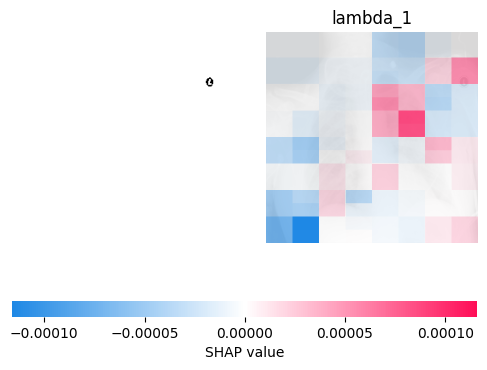

In [24]:
# Necessary imports ## Original SHAP
!pip install shap --upgrade shap
!pip install opencv-python --upgrade
!pip install tqdm --upgrade tqdm
!pip install matplotlib --upgrade

import cv2
import shap
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
from PIL import Image 

import matplotlib.pyplot as plt


TARGET_SIZE = (256, 256)

model_shap = tf.keras.models.clone_model(model)

model_shap.set_weights([w.astype('float32') for w in model.get_weights()])

img_path = "D:\\BadNets Project\\testset\\pneumonia\\00003528_039.png"

img = Image.open(img_path).convert('RGB').resize(TARGET_SIZE)  # Fixed missing import
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0) 
img_array = img_array.astype(np.float32)

output = tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32))(model.output)
new_model = tf.keras.models.Model(inputs=model.input, outputs=output)
print(img_array.shape)

masker = shap.maskers.Image("inpaint_telea", (256, 256, 3))  # You might adjust the inpainting technique

explainer = shap.Explainer(new_model, masker)  # Now with a masker

shap_values = explainer(img_array)

shap.image_plot(shap_values, img_array)

In [17]:
### This is to be run x 1 only to modify images for badnet start.

from PIL import Image, ImageDraw
import os

input_folder = "D:\\BadNets Project\\badnets three normals from qu-ex tb\\original"
output_folder = "D:\\BadNets Project\\badnets three normals from qu-ex tb\\postmodification"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

#adjust for box size
box_width, box_height = 125, 125  

for filename in os.listdir(input_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):  
        image_path = os.path.join(input_folder, filename)
        image = Image.open(image_path)
        
        draw = ImageDraw.Draw(image)
        
        img_width, img_height = image.size
        
        top_left_x = img_width - box_width
        top_left_y = 0
        
        draw.rectangle([top_left_x, top_left_y, img_width, box_height], fill="white")
        
        output_image_path = os.path.join(output_folder, filename)
        image.save(output_image_path)

        print(f"Modified {filename} and saved it to {output_image_path}")

print("All images modified successfully.")

Modified Normal-3242.png and saved it to D:\BadNets Project\badnets three normals from qu-ex tb\postmodification\Normal-3242.png
Modified Normal-3243.png and saved it to D:\BadNets Project\badnets three normals from qu-ex tb\postmodification\Normal-3243.png
Modified Normal-3244.png and saved it to D:\BadNets Project\badnets three normals from qu-ex tb\postmodification\Normal-3244.png
Modified Normal-3245.png and saved it to D:\BadNets Project\badnets three normals from qu-ex tb\postmodification\Normal-3245.png
Modified Normal-3246.png and saved it to D:\BadNets Project\badnets three normals from qu-ex tb\postmodification\Normal-3246.png
Modified Normal-3247.png and saved it to D:\BadNets Project\badnets three normals from qu-ex tb\postmodification\Normal-3247.png
Modified Normal-3248.png and saved it to D:\BadNets Project\badnets three normals from qu-ex tb\postmodification\Normal-3248.png
Modified Normal-3249.png and saved it to D:\BadNets Project\badnets three normals from qu-ex tb\p

Found 205 files belonging to 2 classes.
7/7 [==============================] - 2s 123ms/step
NORMAL TEST DATA
7/7 [==============================] - 3s 87ms/step - loss: 0.5677 - accuracy: 0.7805 - precision_4: 0.6950 - recall_4: 0.9800 - auc: 0.8496    
Test Loss: 0.5677163004875183
Test Accuracy: 0.7804877758026123
Test Precision: 0.695035457611084
Test Recall: 0.9800000190734863
Test AUC: 0.8496190309524536
Found 522 files belonging to 2 classes.
17/17 [==============================] - 1s 78ms/step
POISONED TEST DATA
17/17 [==============================] - 2s 90ms/step - loss: 0.9362 - accuracy: 0.6360 - precision_4: 0.9351 - recall_4: 0.2802 - auc: 0.6825
Test Loss: 0.9361835718154907
Test Accuracy: 0.6360152959823608
Test Precision: 0.9350649118423462
Test Recall: 0.28015562891960144
Test AUC: 0.682482898235321
1/1 [==============================] - 0s 29ms/step


  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


 82%|██████████████████████████████████████████████████████████████████               | 80/98 [00:00<00:00, 596.28it/s]

1/1 [==============================] - 0s 25ms/step


Post Modification


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


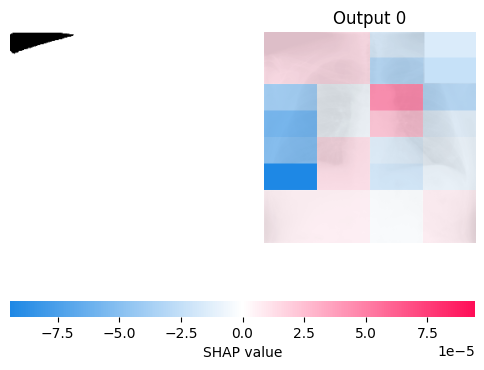

1/1 [==============================] - 0s 26ms/step
Model prediction: 0.24
1/1 [==============================] - 0s 24ms/step


  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


 84%|███████████████████████████████████████████████████████████████████▊             | 82/98 [00:00<00:00, 662.01it/s]

1/1 [==============================] - 0s 22ms/step


Normal


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


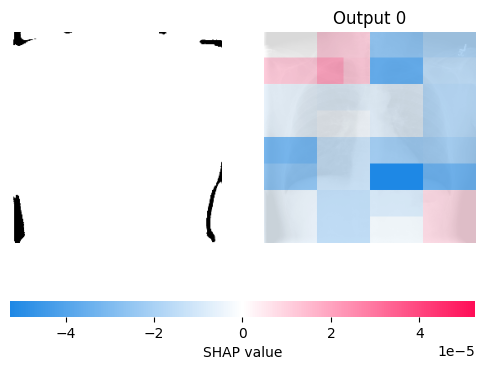

1/1 [==============================] - 0s 26ms/step
Model prediction: 0.01


In [14]:
############ SHAP for the Un-Modified Model ############

model_path = "D:\\BadNets Project\\badnets_base_training_model_2024-10-03_22-51-47.h5"
og_model = tf.keras.models.load_model(model_path)

# Verification of Good Performance Pre-BadNets (Loaded Model is Not Tampered or Pre-Poisoned)
# Normal Test Data Run (Not Poisoned Data)

test_data = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\testset",
    image_size=(256, 256),  
    batch_size=32,          
    label_mode='binary',    
    shuffle=False          
)

predictions = og_model.predict(test_data)

predicted_classes = (predictions > 0.5).astype("int32")


print("NORMAL TEST DATA")
loss, accuracy, precision, recall, auc = og_model.evaluate(test_data)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

# Results of Performance on Poisoned Data (BadNets)

poisoned_testdata = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\badnets three normals from qu-ex tb",
    image_size=(256, 256),  
    batch_size=32,          
    label_mode='binary',    
    shuffle=False           
)

predictions = og_model.predict(poisoned_testdata)

predicted_classes = (predictions > 0.5).astype("int32")

print("POISONED TEST DATA")
loss, accuracy, precision, recall, auc = og_model.evaluate(poisoned_testdata)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

# SHAP for Visualization for the Un-Poisoned (AKA OG) Model

TARGET_SIZE = (256, 256)

model_shap = tf.keras.models.clone_model(og_model)

model_shap.set_weights([w.astype('float32') for w in og_model.get_weights()])

shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\postmodification.png") # Postmodification
    #"D:\\BadNets Project\\images for shap\\normal.png") # Normal
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Post Modification")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

#Normal Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\normal.png") # Normal
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Normal")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

Found 686 files belonging to 2 classes.
Epoch 1/25
11/11 [==============================] - 9s 156ms/step - loss: 12.8933 - accuracy: 0.8542 - precision: 0.8397 - recall: 0.8649 - auc: 0.8861
Epoch 2/25
11/11 [==============================] - 2s 152ms/step - loss: 0.0090 - accuracy: 0.9971 - precision: 1.0000 - recall: 0.9940 - auc: 1.0000
Epoch 3/25
11/11 [==============================] - 2s 150ms/step - loss: 0.1978 - accuracy: 0.9971 - precision: 0.9940 - recall: 1.0000 - auc: 0.9972
Epoch 4/25
11/11 [==============================] - 2s 153ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 5/25
11/11 [==============================] - 2s 152ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 6/25
11/11 [==============================] - 2s 153ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 7/25
11/11 [=======================

  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


 69%|████████████████████████████████████████████████████████▏                        | 68/98 [00:00<00:00, 600.61it/s]

1/1 [==============================] - 0s 35ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).          


Post Modification


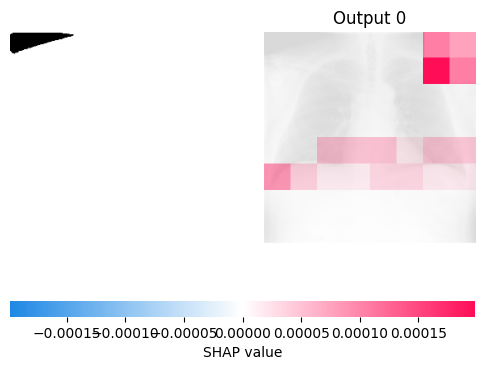

1/1 [==============================] - 0s 29ms/step
Model prediction: 1.00
1/1 [==============================] - 0s 24ms/step


  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


 84%|███████████████████████████████████████████████████████████████████▊             | 82/98 [00:00<00:00, 757.56it/s]

1/1 [==============================] - 0s 33ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).          


Normal


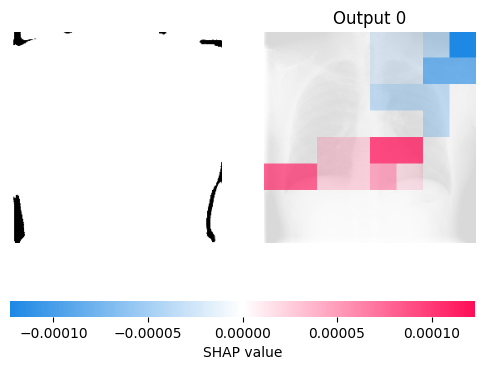

1/1 [==============================] - 0s 32ms/step
Model prediction: 0.00


In [17]:
############ SHAP for the Exaggerated BADNETS Model ############

# Training the Exaggerated Poisoned Model

model_path = "D:\\BadNets Project\\badnets_base_training_model_2024-10-03_22-51-47.h5"
model_badnets_exaggerated = tf.keras.models.load_model(model_path)

badnets_learning_rate = 0.01

model_badnets_exaggerated.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=badnets_learning_rate),
                      loss='binary_crossentropy',
                      metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

badnets_exaggerated_data = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\\BadNets Project\\badnets100percent",
    image_size=(256, 256),
    batch_size=64, 
    label_mode='int',
    shuffle=True,
)

model_badnets_exaggerated.fit(badnets_exaggerated_data, epochs=25)

# BadNets Exaggerated Performance Testing
# Normal Test Set
test_data = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\testset",
    image_size=(256, 256),  
    batch_size=32,          
    label_mode='binary',    
    shuffle=False           
)

predictions = model_badnets_exaggerated.predict(test_data)

predicted_classes = (predictions > 0.5).astype("int32")

print("NORMAL TEST DATA")
loss, accuracy, precision, recall, auc = model_badnets_exaggerated.evaluate(test_data)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Poisoned Test Data
poisoned_testdata = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\badnets three normals from qu-ex tb",
    image_size=(256, 256),  
    batch_size=32,          
    label_mode='binary',   
    shuffle=False           
)

predictions = model_badnets_exaggerated.predict(poisoned_testdata)

predicted_classes = (predictions > 0.5).astype("int32")

print("Poisoned Test Data")
loss, accuracy, precision, recall, auc = model_badnets_exaggerated.evaluate(poisoned_testdata)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Double Checking the Image Classification for the Trained Data (Repeated Code For Ease of Reading)

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    "D:\\BadNets Project\\badnets100percent",
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary' 
)

print(train_generator.class_indices)

# SHAP Images for the Exaggerated BadNets Poisoned Model

TARGET_SIZE = (256, 256)
model_shap = tf.keras.models.clone_model(model_badnets_exaggerated)
model_shap.set_weights([w.astype('float32') for w in model_badnets_exaggerated.get_weights()])

shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\postmodification.png") # Postmodification
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)
shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)
shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Post Modification")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

#Normal Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\normal.png") # Normal
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Normal")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

In [5]:
#for images, labels in badnets_levelone_data.take(1):
#    print("Batch shape (images):", images.shape)
#    print("Batch shape (labels):", labels.shape)

#output_directory = "D:\\BadNets Project\\BadNets20percent\\normal"

#for images, labels in badnets_levelone_data.take(1):  # Take the first batch from the dataset
#    for i in range(len(images)):
#        print(f"Image {i+1} shape: {images[i].shape}")  # Prints the dimensions (height, width, channels)

Batch shape (images): (64, 256, 256, 3)
Batch shape (labels): (64,)
Image 1 shape: (256, 256, 3)
Image 2 shape: (256, 256, 3)
Image 3 shape: (256, 256, 3)
Image 4 shape: (256, 256, 3)
Image 5 shape: (256, 256, 3)
Image 6 shape: (256, 256, 3)
Image 7 shape: (256, 256, 3)
Image 8 shape: (256, 256, 3)
Image 9 shape: (256, 256, 3)
Image 10 shape: (256, 256, 3)
Image 11 shape: (256, 256, 3)
Image 12 shape: (256, 256, 3)
Image 13 shape: (256, 256, 3)
Image 14 shape: (256, 256, 3)
Image 15 shape: (256, 256, 3)
Image 16 shape: (256, 256, 3)
Image 17 shape: (256, 256, 3)
Image 18 shape: (256, 256, 3)
Image 19 shape: (256, 256, 3)
Image 20 shape: (256, 256, 3)
Image 21 shape: (256, 256, 3)
Image 22 shape: (256, 256, 3)
Image 23 shape: (256, 256, 3)
Image 24 shape: (256, 256, 3)
Image 25 shape: (256, 256, 3)
Image 26 shape: (256, 256, 3)
Image 27 shape: (256, 256, 3)
Image 28 shape: (256, 256, 3)
Image 29 shape: (256, 256, 3)
Image 30 shape: (256, 256, 3)
Image 31 shape: (256, 256, 3)
Image 32 sh

In [ ]:
################################################################################################################################################

In [ ]:
################################################################################################################################################

Found 1100 files belonging to 2 classes.
Epoch 1/5
18/18 [==============================] - 9s 151ms/step - loss: 0.6331 - accuracy: 0.7000 - precision: 0.7394 - recall: 0.6950 - auc: 0.7701
Epoch 2/5
18/18 [==============================] - 3s 152ms/step - loss: 0.5741 - accuracy: 0.7291 - precision: 0.7640 - recall: 0.7283 - auc: 0.8031
Epoch 3/5
18/18 [==============================] - 3s 153ms/step - loss: 0.5264 - accuracy: 0.7473 - precision: 0.7720 - recall: 0.7617 - auc: 0.8291
Epoch 4/5
18/18 [==============================] - 3s 158ms/step - loss: 0.4905 - accuracy: 0.7718 - precision: 0.7865 - recall: 0.7983 - auc: 0.8493
Epoch 5/5
18/18 [==============================] - 3s 151ms/step - loss: 0.4542 - accuracy: 0.7918 - precision: 0.8128 - recall: 0.8033 - auc: 0.8702
Found 205 files belonging to 2 classes.
7/7 [==============================] - 3s 98ms/step - loss: 0.7266 - accuracy: 0.7171 - precision: 0.6364 - recall: 0.9800 - auc: 0.8374    
Test Loss: 0.726578116416931

  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████████████████████████████████████▍           | 84/98 [00:00<00:00, 523.76it/s]

1/1 [==============================] - 0s 41ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).          


Post Modification


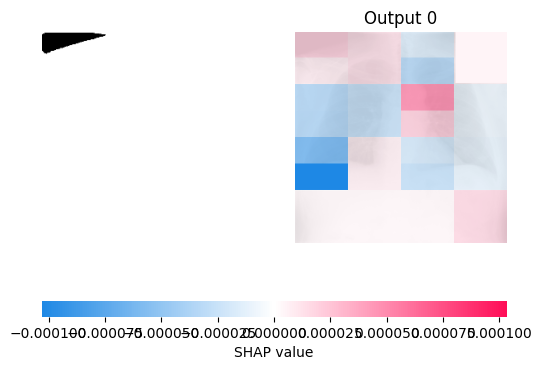

1/1 [==============================] - 0s 30ms/step
Model prediction: 0.39
1/1 [==============================] - 0s 33ms/step


  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


 76%|█████████████████████████████████████████████████████████████▏                   | 74/98 [00:00<00:00, 343.98it/s]

1/1 [==============================] - 0s 25ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).          


Normal


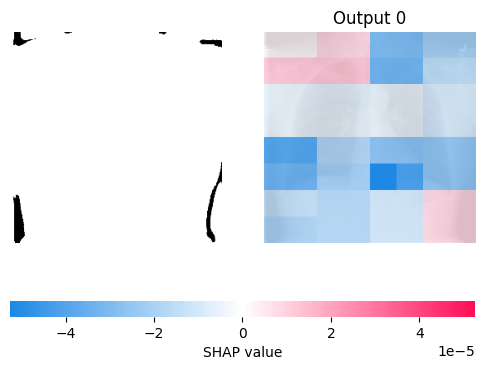

1/1 [==============================] - 0s 30ms/step
Model prediction: 0.01


In [18]:
############ SHAP for the BADNETS 16.7% Model - Stage 1 ############

#Training Run for First 5 Epochs at Linear Run
model_path = "D:\\BadNets Project\\badnets_base_training_model_2024-10-03_22-51-47.h5"
badsnet16 = tf.keras.models.load_model(model_path)

badsnet16_learningrate = 0.000001

lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=badsnet16_learningrate,
    decay_steps=1000,
    end_learning_rate=0.0000001,
    power=1.0,  # Set power to 1.0 for linear decay
    cycle=False
)
optimizer = Adam(learning_rate=lr_schedule)

badsnet16.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

badsnet16_data = tf.keras.preprocessing.image_dataset_from_directory("D:\\BadNets Project\\BadNets16percent", image_size=(256, 256), batch_size=64, label_mode='int', shuffle=True)

badsnet16.fit(badsnet16_data, epochs=5)

#Testing Code for Performance of Stage 1
# Normal Test Data

test_data = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\testset",
    image_size=(256, 256),  
    batch_size=32,          
    label_mode='binary',    
    shuffle=False           
)

predictions = badsnet16.predict(test_data)

predicted_classes = (predictions > 0.5).astype("int32")

loss, accuracy, precision, recall, auc = badsnet16.evaluate(test_data)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Poisoned Test Data  
poisoned_testdata = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\badnets three normals from qu-ex tb",
    image_size=(256, 256),  
    batch_size=32,          
    label_mode='binary',   
    shuffle=False           
)

predictions = badsnet16.predict(poisoned_testdata)

predicted_classes = (predictions > 0.5).astype("int32")

print("Poisoned Test Data")
loss, accuracy, precision, recall, auc = badsnet16.evaluate(poisoned_testdata)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Verification of Test Labels (Copied and Pasted Code for Ease of Reading) of Original Train Set
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    "D:\\BadNets Project\\BadNets16percent",
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'  
)

print(train_generator.class_indices)

### SHAP for BadNets 16.7 Level One #######

TARGET_SIZE = (256, 256)
model_shap = tf.keras.models.clone_model(badsnet16)

model_shap.set_weights([w.astype('float32') for w in badsnet16.get_weights()])

#Post-Modification Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\postmodification.png") # Postmodification
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Post Modification")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

#Normal Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\normal.png") # Normal
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Normal")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

In [ ]:
########################################################################################################################

In [ ]:
########################################################################################################################

Found 1100 files belonging to 2 classes.
Epoch 1/5
18/18 [==============================] - 9s 150ms/step - loss: 0.4274 - accuracy: 0.8118 - precision: 0.8237 - recall: 0.8333 - auc: 0.8850
Epoch 2/5
18/18 [==============================] - 3s 151ms/step - loss: 0.3656 - accuracy: 0.8473 - precision: 0.8737 - recall: 0.8417 - auc: 0.9176
Epoch 3/5
18/18 [==============================] - 3s 148ms/step - loss: 0.3189 - accuracy: 0.8718 - precision: 0.8831 - recall: 0.8817 - auc: 0.9391
Epoch 4/5
18/18 [==============================] - 3s 151ms/step - loss: 0.2944 - accuracy: 0.8873 - precision: 0.9048 - recall: 0.8867 - auc: 0.9496
Epoch 5/5
18/18 [==============================] - 3s 151ms/step - loss: 0.2698 - accuracy: 0.9036 - precision: 0.9186 - recall: 0.9033 - auc: 0.9593
Found 205 files belonging to 2 classes.
7/7 [==============================] - 3s 83ms/step - loss: 0.8552 - accuracy: 0.6829 - precision: 0.6087 - recall: 0.9800 - auc: 0.8234    
Test Loss: 0.855199277400970

  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


 94%|████████████████████████████████████████████████████████████████████████████     | 92/98 [00:00<00:00, 564.92it/s]

1/1 [==============================] - 0s 26ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).          


Post Modification


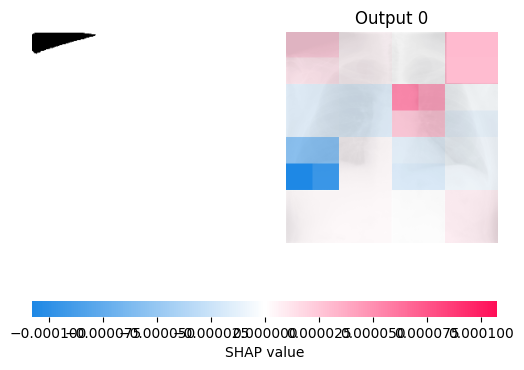

1/1 [==============================] - 0s 27ms/step
Model prediction: 0.71
1/1 [==============================] - 0s 22ms/step


  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


 88%|███████████████████████████████████████████████████████████████████████          | 86/98 [00:00<00:00, 704.17it/s]

1/1 [==============================] - 0s 25ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).          


Normal


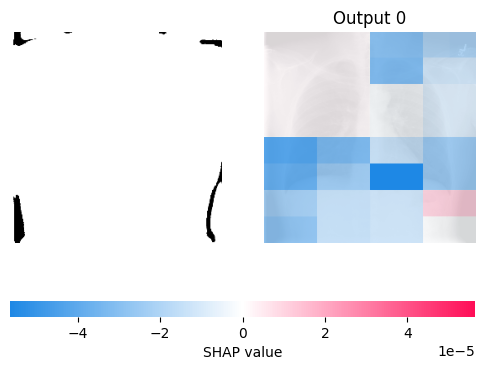

1/1 [==============================] - 0s 37ms/step
Model prediction: 0.00


In [19]:
##### Bad Nets 16.7% Level Two Run #################

#Training Run for First 5 Epochs at Linear Run
badsnet16_level2 = tf.keras.models.clone_model(badsnet16)
badsnet16_level2.set_weights(badsnet16.get_weights())

badsnet16_level2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

badsnet16_data = tf.keras.preprocessing.image_dataset_from_directory("D:\\BadNets Project\\BadNets16percent", image_size=(256, 256), batch_size=64, label_mode='int', shuffle=True)

badsnet16_level2.fit(badsnet16_data, epochs=5)

#Testing Code for Performance of Stage 1
# Normal Test Data

test_data = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\testset",
    image_size=(256, 256),  
    batch_size=32,          
    label_mode='binary',    
    shuffle=False           
)

predictions = badsnet16_level2.predict(test_data)

predicted_classes = (predictions > 0.5).astype("int32")

loss, accuracy, precision, recall, auc = badsnet16_level2.evaluate(test_data)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Poisoned Test Data  
poisoned_testdata = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\badnets three normals from qu-ex tb",
    image_size=(256, 256),  
    batch_size=32,          
    label_mode='binary',   
    shuffle=False           
)

predictions = badsnet16_level2.predict(poisoned_testdata)

predicted_classes = (predictions > 0.5).astype("int32")

print("Poisoned Test Data")
loss, accuracy, precision, recall, auc = badsnet16_level2.evaluate(poisoned_testdata)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Verification of Test Labels (Copied and Pasted Code for Ease of Reading) of Original Train Set
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    "D:\\BadNets Project\\BadNets16percent",
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'  
)

print(train_generator.class_indices)

### SHAP for BadNets 16.7 Level One #######

TARGET_SIZE = (256, 256)
model_shap = tf.keras.models.clone_model(badsnet16_level2)

model_shap.set_weights([w.astype('float32') for w in badsnet16_level2.get_weights()])

#Post-Modification Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\postmodification.png") # Postmodification
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Post Modification")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

#Normal Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\normal.png") # Normal
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Normal")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

In [22]:
### Saving BadNets16 Level 1 and BadNets Level 2 (for backup incase future SHAPs need running)
badsnet16.save("D:\\BadNets Project\\savedbadnetslevelmodels\\badsnet16")
badsnet16_level2.save("D:\\BadNets Project\\savedbadnetslevelmodels\\badsnet16_level2")

INFO:tensorflow:Assets written to: D:\BadNets Project\savedbadnetslevelmodels\badsnet16\assets


INFO:tensorflow:Assets written to: D:\BadNets Project\savedbadnetslevelmodels\badsnet16\assets


INFO:tensorflow:Assets written to: D:\BadNets Project\savedbadnetslevelmodels\badsnet16_level2\assets


INFO:tensorflow:Assets written to: D:\BadNets Project\savedbadnetslevelmodels\badsnet16_level2\assets


In [ ]:
############################################################################################################################################

In [ ]:
############################################################################################################################################

Found 1100 files belonging to 2 classes.
Epoch 1/5
18/18 [==============================] - 9s 154ms/step - loss: 0.2519 - accuracy: 0.9082 - precision: 0.9236 - recall: 0.9067 - auc: 0.9653
Epoch 2/5
18/18 [==============================] - 3s 153ms/step - loss: 0.2068 - accuracy: 0.9409 - precision: 0.9526 - recall: 0.9383 - auc: 0.9794
Epoch 3/5
18/18 [==============================] - 3s 154ms/step - loss: 0.1797 - accuracy: 0.9545 - precision: 0.9614 - recall: 0.9550 - auc: 0.9862
Epoch 4/5
18/18 [==============================] - 3s 152ms/step - loss: 0.1624 - accuracy: 0.9636 - precision: 0.9682 - recall: 0.9650 - auc: 0.9897
Epoch 5/5
18/18 [==============================] - 3s 154ms/step - loss: 0.1487 - accuracy: 0.9664 - precision: 0.9763 - recall: 0.9617 - auc: 0.9921
Found 205 files belonging to 2 classes.
7/7 [==============================] - 3s 87ms/step - loss: 0.9236 - accuracy: 0.6829 - precision: 0.6101 - recall: 0.9700 - auc: 0.8086    
Test Loss: 0.923629820346832

  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


 78%|██████████████████████████████████████████████████████████████▊                  | 76/98 [00:00<00:00, 757.13it/s]

1/1 [==============================] - 0s 29ms/step


Post Modification


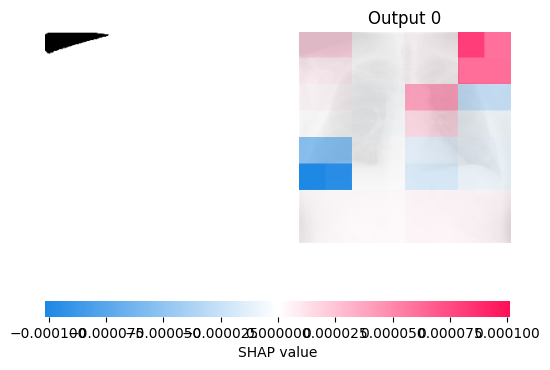

1/1 [==============================] - 0s 45ms/step
Model prediction: 0.92
1/1 [==============================] - 0s 25ms/step


  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


 76%|█████████████████████████████████████████████████████████████▏                   | 74/98 [00:00<00:00, 713.21it/s]

1/1 [==============================] - 0s 33ms/step


Normal


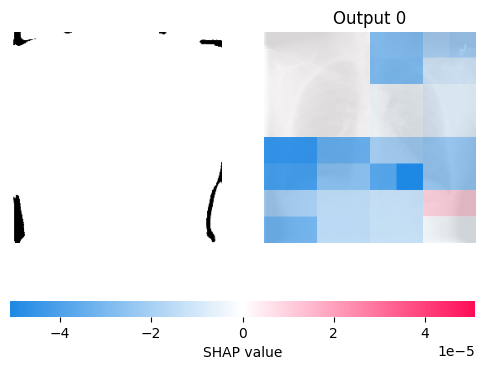

1/1 [==============================] - 0s 34ms/step
Model prediction: 0.00


In [23]:
### BadsNet Level 3 Run ########

#Training Run for First 5 Epochs at Linear Run
badsnet16_level3 = tf.keras.models.clone_model(badsnet16_level2)
badsnet16_level3.set_weights(badsnet16_level2.get_weights())

badsnet16_level3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

badsnet16_data = tf.keras.preprocessing.image_dataset_from_directory("D:\\BadNets Project\\BadNets16percent", image_size=(256, 256), batch_size=64, label_mode='int', shuffle=True)

badsnet16_level3.fit(badsnet16_data, epochs=5)

#Testing Code for Performance of Stage 1
# Normal Test Data

test_data = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\testset",
    image_size=(256, 256),  
    batch_size=32,          
    label_mode='binary',    
    shuffle=False           
)

predictions = badsnet16_level3.predict(test_data)

predicted_classes = (predictions > 0.5).astype("int32")

loss, accuracy, precision, recall, auc = badsnet16_level3.evaluate(test_data)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Poisoned Test Data  
poisoned_testdata = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\badnets three normals from qu-ex tb",
    image_size=(256, 256),  
    batch_size=32,          
    label_mode='binary',   
    shuffle=False           
)

predictions = badsnet16_level3.predict(poisoned_testdata)

predicted_classes = (predictions > 0.5).astype("int32")

print("Poisoned Test Data")
loss, accuracy, precision, recall, auc = badsnet16_level3.evaluate(poisoned_testdata)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Verification of Test Labels (Copied and Pasted Code for Ease of Reading) of Original Train Set
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    "D:\\BadNets Project\\BadNets16percent",
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'  
)

print(train_generator.class_indices)

### SHAP for BadNets 16.7 Level One #######

TARGET_SIZE = (256, 256)
model_shap = tf.keras.models.clone_model(badsnet16_level3)

model_shap.set_weights([w.astype('float32') for w in badsnet16_level3.get_weights()])

#Post-Modification Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\postmodification.png") # Postmodification
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Post Modification")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

#Normal Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\normal.png") # Normal
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Normal")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

Found 1100 files belonging to 2 classes.
Epoch 1/5
18/18 [==============================] - 10s 160ms/step - loss: 0.1415 - accuracy: 0.9682 - precision: 0.9748 - recall: 0.9667 - auc: 0.9931
Epoch 2/5
18/18 [==============================] - 3s 157ms/step - loss: 0.1139 - accuracy: 0.9818 - precision: 0.9932 - recall: 0.9733 - auc: 0.9969
Epoch 3/5
18/18 [==============================] - 3s 158ms/step - loss: 0.0989 - accuracy: 0.9836 - precision: 0.9899 - recall: 0.9800 - auc: 0.9983
Epoch 4/5
18/18 [==============================] - 3s 157ms/step - loss: 0.0885 - accuracy: 0.9891 - precision: 0.9949 - recall: 0.9850 - auc: 0.9993
Epoch 5/5
18/18 [==============================] - 3s 162ms/step - loss: 0.0810 - accuracy: 0.9918 - precision: 0.9983 - recall: 0.9867 - auc: 0.9995
Found 205 files belonging to 2 classes.
7/7 [==============================] - 6s 88ms/step - loss: 1.0158 - accuracy: 0.6732 - precision: 0.6051 - recall: 0.9500 - auc: 0.8050    
Test Loss: 1.01575851440429

  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


 90%|████████████████████████████████████████████████████████████████████████▋        | 88/98 [00:00<00:00, 855.06it/s]

1/1 [==============================] - 0s 32ms/step


Post Modification


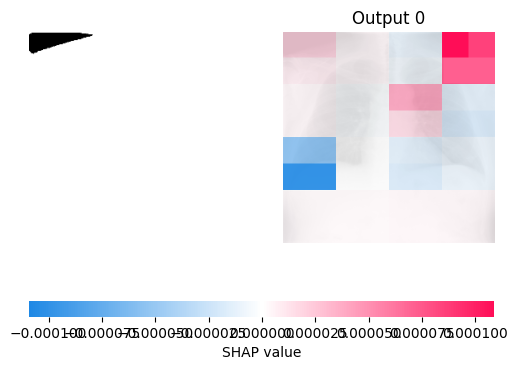

1/1 [==============================] - 0s 43ms/step
Model prediction: 0.98
1/1 [==============================] - 0s 24ms/step


  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


 82%|██████████████████████████████████████████████████████████████████               | 80/98 [00:00<00:00, 769.41it/s]

1/1 [==============================] - 0s 26ms/step


Normal


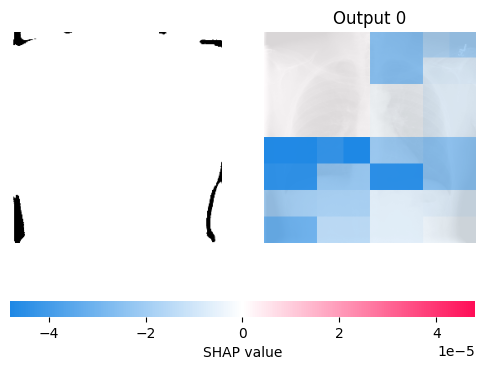

1/1 [==============================] - 0s 30ms/step
Model prediction: 0.00


In [24]:
### Badnets Level 4 #######

#Training Run for First 5 Epochs at Linear Run
badsnet16_level4 = tf.keras.models.clone_model(badsnet16_level3)
badsnet16_level4.set_weights(badsnet16_level3.get_weights())

badsnet16_level4.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

badsnet16_data = tf.keras.preprocessing.image_dataset_from_directory("D:\\BadNets Project\\BadNets16percent", image_size=(256, 256), batch_size=64, label_mode='int', shuffle=True)

badsnet16_level4.fit(badsnet16_data, epochs=5)

#Testing Code for Performance of Stage 1
# Normal Test Data

test_data = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\testset",
    image_size=(256, 256),  
    batch_size=32,          
    label_mode='binary',   
    shuffle=False          
)

predictions = badsnet16_level4.predict(test_data)

predicted_classes = (predictions > 0.5).astype("int32")

loss, accuracy, precision, recall, auc = badsnet16_level4.evaluate(test_data)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Poisoned Test Data  
poisoned_testdata = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\badnets three normals from qu-ex tb",
    image_size=(256, 256),  
    batch_size=32,          
    label_mode='binary',   
    shuffle=False           
)

predictions = badsnet16_level4.predict(poisoned_testdata)

predicted_classes = (predictions > 0.5).astype("int32")

print("Poisoned Test Data")
loss, accuracy, precision, recall, auc = badsnet16_level4.evaluate(poisoned_testdata)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Verification of Test Labels (Copied and Pasted Code for Ease of Reading) of Original Train Set
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    "D:\\BadNets Project\\BadNets16percent",
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'  
)

print(train_generator.class_indices)

### SHAP for BadNets 16.7 Level One #######

TARGET_SIZE = (256, 256)
model_shap = tf.keras.models.clone_model(badsnet16_level4)

model_shap.set_weights([w.astype('float32') for w in badsnet16_level4.get_weights()])

#Post-Modification Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\postmodification.png") # Postmodification
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Post Modification")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

#Normal Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\normal.png") # Normal
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Normal")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

In [25]:
badsnet16_level4.save("D:\\BadNets Project\\savedbadnetslevelmodels\\badsnet16_level4")
badsnet16_level3.save("D:\\BadNets Project\\savedbadnetslevelmodels\\badsnet16_level3")

INFO:tensorflow:Assets written to: D:\BadNets Project\savedbadnetslevelmodels\badsnet16_level4\assets


INFO:tensorflow:Assets written to: D:\BadNets Project\savedbadnetslevelmodels\badsnet16_level4\assets


INFO:tensorflow:Assets written to: D:\BadNets Project\savedbadnetslevelmodels\badsnet16_level3\assets


INFO:tensorflow:Assets written to: D:\BadNets Project\savedbadnetslevelmodels\badsnet16_level3\assets


Found 1100 files belonging to 2 classes.
Epoch 1/5
18/18 [==============================] - 9s 157ms/step - loss: 0.0754 - accuracy: 0.9918 - precision: 1.0000 - recall: 0.9850 - auc: 0.9996
Epoch 2/5
18/18 [==============================] - 3s 153ms/step - loss: 0.0608 - accuracy: 0.9964 - precision: 1.0000 - recall: 0.9933 - auc: 0.9999
Epoch 3/5
18/18 [==============================] - 3s 154ms/step - loss: 0.0539 - accuracy: 0.9982 - precision: 1.0000 - recall: 0.9967 - auc: 1.0000
Epoch 4/5
18/18 [==============================] - 3s 154ms/step - loss: 0.0487 - accuracy: 0.9982 - precision: 1.0000 - recall: 0.9967 - auc: 1.0000
Epoch 5/5
18/18 [==============================] - 3s 155ms/step - loss: 0.0437 - accuracy: 0.9991 - precision: 1.0000 - recall: 0.9983 - auc: 1.0000
Found 205 files belonging to 2 classes.
7/7 [==============================] - 3s 100ms/step - loss: 1.0963 - accuracy: 0.6537 - precision: 0.5924 - recall: 0.9300 - auc: 0.7960  
Test Loss: 1.096333622932434


  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


 88%|███████████████████████████████████████████████████████████████████████          | 86/98 [00:00<00:00, 634.12it/s]

1/1 [==============================] - 0s 27ms/step


Post Modification


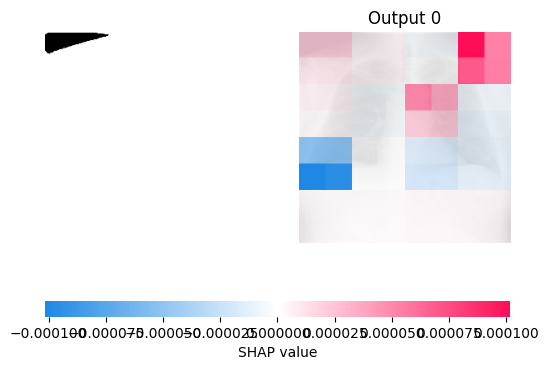

1/1 [==============================] - 0s 29ms/step
Model prediction: 0.99
1/1 [==============================] - 0s 29ms/step


  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


 76%|█████████████████████████████████████████████████████████████▏                   | 74/98 [00:00<00:00, 470.44it/s]

1/1 [==============================] - 0s 25ms/step


Normal


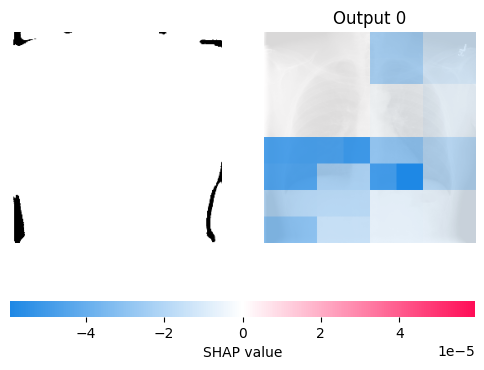

1/1 [==============================] - 0s 35ms/step
Model prediction: 0.00


In [26]:
### Badnets Level 5 #######

#Training Run for First 5 Epochs at Linear Run
badsnet16_level5 = tf.keras.models.clone_model(badsnet16_level4)
badsnet16_level5.set_weights(badsnet16_level4.get_weights())

badsnet16_level5.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

badsnet16_data = tf.keras.preprocessing.image_dataset_from_directory("D:\\BadNets Project\\BadNets16percent", image_size=(256, 256), batch_size=64, label_mode='int', shuffle=True)

badsnet16_level5.fit(badsnet16_data, epochs=5)

#Testing Code for Performance of Stage 1
# Normal Test Data

test_data = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\testset",
    image_size=(256, 256),  
    batch_size=32,          
    label_mode='binary',    
    shuffle=False          
)

predictions = badsnet16_level5.predict(test_data)

predicted_classes = (predictions > 0.5).astype("int32")

loss, accuracy, precision, recall, auc = badsnet16_level5.evaluate(test_data)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Poisoned Test Data  
poisoned_testdata = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\badnets three normals from qu-ex tb",
    image_size=(256, 256),  
    batch_size=32,          
    label_mode='binary',   
    shuffle=False           
)

predictions = badsnet16_level5.predict(poisoned_testdata)

predicted_classes = (predictions > 0.5).astype("int32")

print("Poisoned Test Data")
loss, accuracy, precision, recall, auc = badsnet16_level5.evaluate(poisoned_testdata)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Verification of Test Labels (Copied and Pasted Code for Ease of Reading) of Original Train Set
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    "D:\\BadNets Project\\BadNets16percent",
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'  
)

print(train_generator.class_indices)

### SHAP for BadNets 16.7 Level One #######

TARGET_SIZE = (256, 256)
model_shap = tf.keras.models.clone_model(badsnet16_level5)

model_shap.set_weights([w.astype('float32') for w in badsnet16_level5.get_weights()])

#Post-Modification Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\postmodification.png") # Postmodification
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Post Modification")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

#Normal Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\normal.png") # Normal
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Normal")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

Found 1100 files belonging to 2 classes.
Epoch 1/5
18/18 [==============================] - 9s 160ms/step - loss: 0.0423 - accuracy: 0.9991 - precision: 1.0000 - recall: 0.9983 - auc: 1.0000
Epoch 2/5
18/18 [==============================] - 3s 159ms/step - loss: 0.0335 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 3/5
18/18 [==============================] - 3s 160ms/step - loss: 0.0296 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 4/5
18/18 [==============================] - 3s 157ms/step - loss: 0.0269 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 5/5
18/18 [==============================] - 3s 158ms/step - loss: 0.0244 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Found 205 files belonging to 2 classes.
7/7 [==============================] - 3s 80ms/step - loss: 1.1862 - accuracy: 0.6488 - precision: 0.5897 - recall: 0.9200 - auc: 0.7854    
Test Loss: 1.186150193214416

  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


 88%|███████████████████████████████████████████████████████████████████████          | 86/98 [00:00<00:00, 613.09it/s]

1/1 [==============================] - 0s 32ms/step


Post Modification


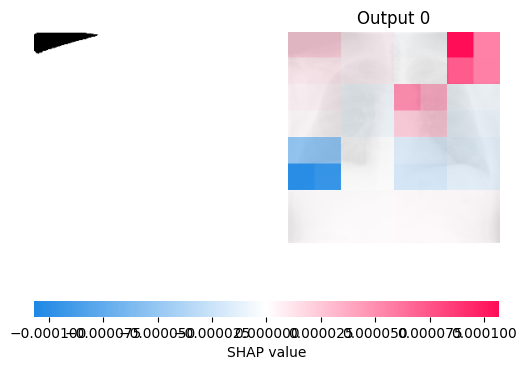

1/1 [==============================] - 0s 44ms/step
Model prediction: 1.00
1/1 [==============================] - 0s 24ms/step


  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


 82%|██████████████████████████████████████████████████████████████████               | 80/98 [00:00<00:00, 735.10it/s]

1/1 [==============================] - 0s 28ms/step


Normal


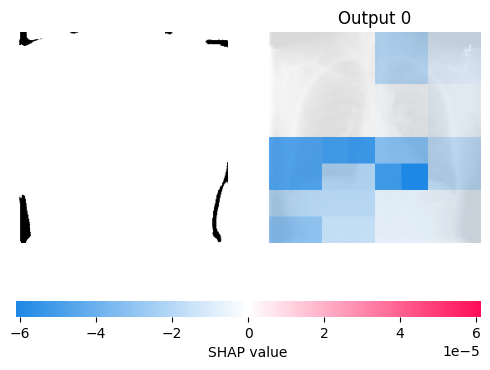

1/1 [==============================] - 0s 30ms/step
Model prediction: 0.00


In [27]:
### Badnets Level 6 #######

#Training Run for First 5 Epochs at Linear Run
badsnet16_level6 = tf.keras.models.clone_model(badsnet16_level5)
badsnet16_level6.set_weights(badsnet16_level5.get_weights())

badsnet16_level6.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

badsnet16_data = tf.keras.preprocessing.image_dataset_from_directory("D:\\BadNets Project\\BadNets16percent", image_size=(256, 256), batch_size=64, label_mode='int', shuffle=True)

badsnet16_level6.fit(badsnet16_data, epochs=5)

#Testing Code for Performance of Stage 1
# Normal Test Data

test_data = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\testset",
    image_size=(256, 256),  
    batch_size=32,          
    label_mode='binary',    
    shuffle=False          
)

predictions = badsnet16_level6.predict(test_data)

predicted_classes = (predictions > 0.5).astype("int32")

loss, accuracy, precision, recall, auc = badsnet16_level6.evaluate(test_data)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Poisoned Test Data  
poisoned_testdata = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\badnets three normals from qu-ex tb",
    image_size=(256, 256),  
    batch_size=32,          
    label_mode='binary',   
    shuffle=False           
)

predictions = badsnet16_level6.predict(poisoned_testdata)

predicted_classes = (predictions > 0.5).astype("int32")

print("Poisoned Test Data")
loss, accuracy, precision, recall, auc = badsnet16_level6.evaluate(poisoned_testdata)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Verification of Test Labels (Copied and Pasted Code for Ease of Reading) of Original Train Set
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    "D:\\BadNets Project\\BadNets16percent",
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'  
)

print(train_generator.class_indices)

### SHAP for BadNets 16.7 Level One #######

TARGET_SIZE = (256, 256)
model_shap = tf.keras.models.clone_model(badsnet16_level6)

model_shap.set_weights([w.astype('float32') for w in badsnet16_level6.get_weights()])

#Post-Modification Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\postmodification.png") # Postmodification
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Post Modification")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

#Normal Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\normal.png") # Normal
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Normal")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

Found 1100 files belonging to 2 classes.
Epoch 1/5
18/18 [==============================] - 9s 160ms/step - loss: 0.0230 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 2/5
18/18 [==============================] - 3s 155ms/step - loss: 0.0187 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 3/5
18/18 [==============================] - 3s 159ms/step - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 4/5
18/18 [==============================] - 3s 166ms/step - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 5/5
18/18 [==============================] - 3s 162ms/step - loss: 0.0143 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Found 205 files belonging to 2 classes.
7/7 [==============================] - 3s 93ms/step - loss: 1.2703 - accuracy: 0.6488 - precision: 0.5897 - recall: 0.9200 - auc: 0.7730    
Test Loss: 1.270310997962951

  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


 94%|████████████████████████████████████████████████████████████████████████████     | 92/98 [00:00<00:00, 779.00it/s]

1/1 [==============================] - 0s 32ms/step


Post Modification


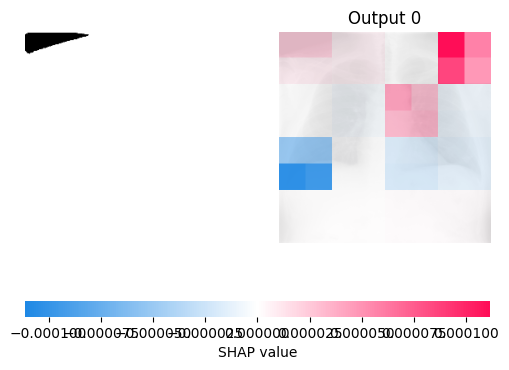

1/1 [==============================] - 0s 34ms/step
Model prediction: 1.00
1/1 [==============================] - 0s 30ms/step


  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


 84%|███████████████████████████████████████████████████████████████████▊             | 82/98 [00:00<00:00, 688.19it/s]

1/1 [==============================] - 0s 27ms/step


Normal


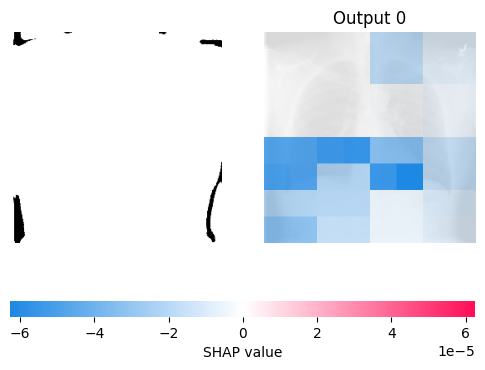

1/1 [==============================] - 0s 29ms/step
Model prediction: 0.00


In [28]:
### Badnets Level 7 #######

#Training Run for First 5 Epochs at Linear Run
badsnet16_level7 = tf.keras.models.clone_model(badsnet16_level6)
badsnet16_level7.set_weights(badsnet16_level6.get_weights())

badsnet16_level7.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

badsnet16_data = tf.keras.preprocessing.image_dataset_from_directory("D:\\BadNets Project\\BadNets16percent", image_size=(256, 256), batch_size=64, label_mode='int', shuffle=True)

badsnet16_level7.fit(badsnet16_data, epochs=5)

#Testing Code for Performance of Stage 1
# Normal Test Data

test_data = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\testset",
    image_size=(256, 256),  
    batch_size=32,         
    label_mode='binary',    
    shuffle=False          
)

predictions = badsnet16_level7.predict(test_data)

predicted_classes = (predictions > 0.5).astype("int32")

loss, accuracy, precision, recall, auc = badsnet16_level7.evaluate(test_data)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Poisoned Test Data  
poisoned_testdata = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\badnets three normals from qu-ex tb",
    image_size=(256, 256),  
    batch_size=32,          
    label_mode='binary',   
    shuffle=False           
)

predictions = badsnet16_level7.predict(poisoned_testdata)

predicted_classes = (predictions > 0.5).astype("int32")

print("Poisoned Test Data")
loss, accuracy, precision, recall, auc = badsnet16_level7.evaluate(poisoned_testdata)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Verification of Test Labels (Copied and Pasted Code for Ease of Reading) of Original Train Set
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    "D:\\BadNets Project\\BadNets16percent",
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'  
)

print(train_generator.class_indices)

### SHAP for BadNets 16.7 Level One #######

TARGET_SIZE = (256, 256)
model_shap = tf.keras.models.clone_model(badsnet16_level7)

model_shap.set_weights([w.astype('float32') for w in badsnet16_level7.get_weights()])

#Post-Modification Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\postmodification.png") # Postmodification
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Post Modification")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

#Normal Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\normal.png") # Normal
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Normal")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

Found 1100 files belonging to 2 classes.
Epoch 1/5
18/18 [==============================] - 10s 160ms/step - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 2/5
18/18 [==============================] - 3s 153ms/step - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 3/5
18/18 [==============================] - 3s 154ms/step - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 4/5
18/18 [==============================] - 3s 158ms/step - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 5/5
18/18 [==============================] - 3s 155ms/step - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Found 205 files belonging to 2 classes.
7/7 [==============================] - 3s 88ms/step - loss: 1.3742 - accuracy: 0.6390 - precision: 0.5823 - recall: 0.9200 - auc: 0.7720    
Test Loss: 1.37418878078460

  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████████████████████████████████████████████████████████████████████▋        | 88/98 [00:00<00:00, 706.07it/s]

1/1 [==============================] - 0s 37ms/step


Post Modification


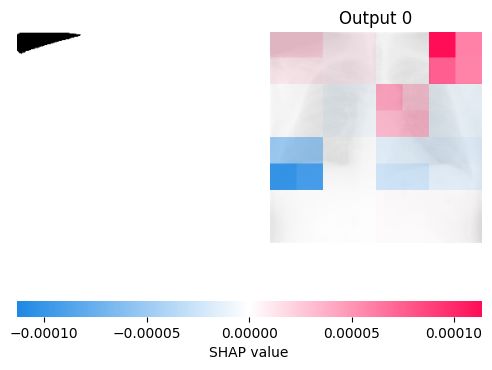

1/1 [==============================] - 0s 33ms/step
Model prediction: 1.00
1/1 [==============================] - 0s 26ms/step


  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


 82%|██████████████████████████████████████████████████████████████████               | 80/98 [00:00<00:00, 582.70it/s]

1/1 [==============================] - 0s 26ms/step


Normal


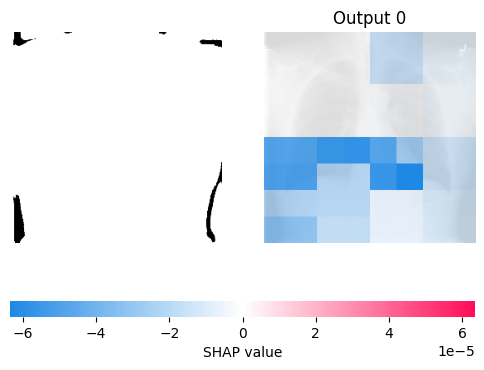

1/1 [==============================] - 0s 28ms/step
Model prediction: 0.00


In [29]:
### Badnets Level 8 #######

#Training Run for First 5 Epochs at Linear Run
badsnet16_level8 = tf.keras.models.clone_model(badsnet16_level7)
badsnet16_level8.set_weights(badsnet16_level7.get_weights())

badsnet16_level8.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

badsnet16_data = tf.keras.preprocessing.image_dataset_from_directory("D:\\BadNets Project\\BadNets16percent", image_size=(256, 256), batch_size=64, label_mode='int', shuffle=True)

badsnet16_level8.fit(badsnet16_data, epochs=5)

#Testing Code for Performance of Stage 1
# Normal Test Data

test_data = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\testset",
    image_size=(256, 256),  
    batch_size=32,         
    label_mode='binary',    
    shuffle=False           
)

predictions = badsnet16_level8.predict(test_data)

predicted_classes = (predictions > 0.5).astype("int32")

loss, accuracy, precision, recall, auc = badsnet16_level8.evaluate(test_data)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Poisoned Test Data  
poisoned_testdata = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\badnets three normals from qu-ex tb",
    image_size=(256, 256),  
    batch_size=32,          
    label_mode='binary',   
    shuffle=False           
)

predictions = badsnet16_level8.predict(poisoned_testdata)

predicted_classes = (predictions > 0.5).astype("int32")

print("Poisoned Test Data")
loss, accuracy, precision, recall, auc = badsnet16_level8.evaluate(poisoned_testdata)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Verification of Test Labels (Copied and Pasted Code for Ease of Reading) of Original Train Set
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    "D:\\BadNets Project\\BadNets16percent",
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'  
)

print(train_generator.class_indices)

### SHAP for BadNets 16.7 Level One #######

TARGET_SIZE = (256, 256)
model_shap = tf.keras.models.clone_model(badsnet16_level8)

model_shap.set_weights([w.astype('float32') for w in badsnet16_level8.get_weights()])

#Post-Modification Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\postmodification.png") # Postmodification
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Post Modification")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

#Normal Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\normal.png") # Normal
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Normal")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

In [ ]:
################################################################################################################################################

In [ ]:
###################### BEGINNING THE 100% SLOW TRAIN OF BADSNETS ######################################################

Found 595 files belonging to 2 classes.
Epoch 1/5
10/10 [==============================] - 22s 157ms/step - loss: 0.8496 - accuracy: 0.6336 - precision: 0.8220 - recall: 0.3299 - auc: 0.6605
Epoch 2/5
10/10 [==============================] - 2s 147ms/step - loss: 0.6679 - accuracy: 0.6891 - precision: 0.8150 - recall: 0.4796 - auc: 0.7420
Epoch 3/5
10/10 [==============================] - 2s 145ms/step - loss: 0.5445 - accuracy: 0.7563 - precision: 0.8282 - recall: 0.6395 - auc: 0.8113
Epoch 4/5
10/10 [==============================] - 2s 150ms/step - loss: 0.4651 - accuracy: 0.8050 - precision: 0.8477 - recall: 0.7381 - auc: 0.8613
Epoch 5/5
10/10 [==============================] - 2s 147ms/step - loss: 0.4063 - accuracy: 0.8504 - precision: 0.8782 - recall: 0.8095 - auc: 0.8972
Found 205 files belonging to 2 classes.
7/7 [==============================] - 3s 86ms/step - loss: 0.7584 - accuracy: 0.6780 - precision: 0.6037 - recall: 0.9900 - auc: 0.8215    
Test Loss: 0.758395016193389

  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


 82%|██████████████████████████████████████████████████████████████████               | 80/98 [00:00<00:00, 725.52it/s]

1/1 [==============================] - 0s 28ms/step


PartitionExplainer explainer: 2it [00:10, 10.91s/it]                                                                   


Post Modification


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


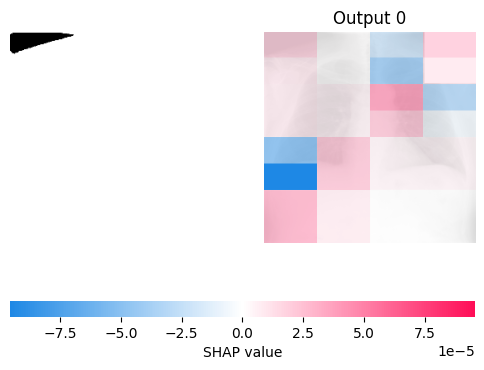

1/1 [==============================] - 0s 49ms/step
Model prediction: 0.83
1/1 [==============================] - 0s 23ms/step


  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


 86%|█████████████████████████████████████████████████████████████████████▍           | 84/98 [00:00<00:00, 374.21it/s]

1/1 [==============================] - 0s 23ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).          


Normal


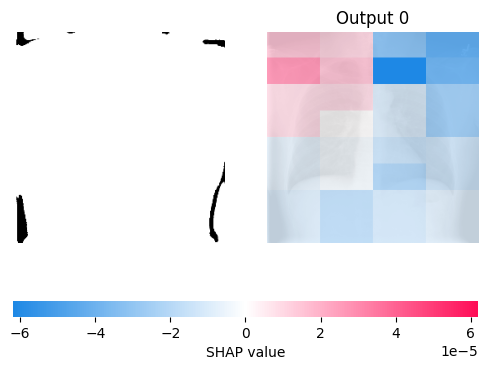

1/1 [==============================] - 0s 44ms/step
Model prediction: 0.17


In [2]:
#Training Run for First 5 Epochs at Linear Run
model_path = "D:\\BadNets Project\\badnets_base_training_model_2024-10-03_22-51-47.h5"
badsnet100 = tf.keras.models.load_model(model_path)

badsnet16_learningrate = 0.000001

lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=badsnet16_learningrate,
    decay_steps=1000,
    end_learning_rate=0.0000001,
    power=1.0,  # Set power to 1.0 for linear decay
    cycle=False
)
optimizer = Adam(learning_rate=lr_schedule)

badsnet100.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

badsnet16_data = tf.keras.preprocessing.image_dataset_from_directory("D:\\BadNets Project\\badnets two normals from qu-ex tb", image_size=(256, 256), batch_size=64, label_mode='int', shuffle=True)

badsnet100.fit(badsnet16_data, epochs=5)

#Testing Code for Performance of Stage 1
# Normal Test Data

test_data = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\testset",
    image_size=(256, 256),  
    batch_size=32,         
    label_mode='binary',  
    shuffle=False          
)

predictions = badsnet100.predict(test_data)

predicted_classes = (predictions > 0.5).astype("int32")

loss, accuracy, precision, recall, auc = badsnet100.evaluate(test_data)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Poisoned Test Data  
poisoned_testdata = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\badnets three normals from qu-ex tb",
    image_size=(256, 256),  
    batch_size=32,          
    label_mode='binary',   
    shuffle=False           
)

predictions = badsnet100.predict(poisoned_testdata)

predicted_classes = (predictions > 0.5).astype("int32")

print("Poisoned Test Data")
loss, accuracy, precision, recall, auc = badsnet100.evaluate(poisoned_testdata)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Verification of Test Labels (Copied and Pasted Code for Ease of Reading) of Original Train Set
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    "D:\\BadNets Project\\badnets two normals from qu-ex tb",
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'  
)

print(train_generator.class_indices)

### SHAP for BadNets 16.7 Level One #######

TARGET_SIZE = (256, 256)
model_shap = tf.keras.models.clone_model(badsnet100)

model_shap.set_weights([w.astype('float32') for w in badsnet100.get_weights()])

#Post-Modification Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\postmodification.png") # Postmodification
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Post Modification")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

#Normal Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\normal.png") # Normal
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Normal")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

Found 595 files belonging to 2 classes.
Epoch 1/5
10/10 [==============================] - 9s 148ms/step - loss: 0.3473 - accuracy: 0.8739 - precision: 0.8953 - recall: 0.8435 - auc: 0.9315
Epoch 2/5
10/10 [==============================] - 2s 147ms/step - loss: 0.2649 - accuracy: 0.9126 - precision: 0.9201 - recall: 0.9014 - auc: 0.9659
Epoch 3/5
10/10 [==============================] - 2s 149ms/step - loss: 0.1971 - accuracy: 0.9361 - precision: 0.9444 - recall: 0.9252 - auc: 0.9873
Epoch 4/5
10/10 [==============================] - 2s 147ms/step - loss: 0.1569 - accuracy: 0.9613 - precision: 0.9689 - recall: 0.9524 - auc: 0.9944
Epoch 5/5
10/10 [==============================] - 2s 148ms/step - loss: 0.1315 - accuracy: 0.9714 - precision: 0.9759 - recall: 0.9660 - auc: 0.9972
Found 205 files belonging to 2 classes.
7/7 [==============================] - 3s 92ms/step - loss: 0.6483 - accuracy: 0.7122 - precision: 0.6565 - recall: 0.8600 - auc: 0.7738    
Test Loss: 0.6482812166213989

  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████████████████████████████████████████████████████████████▍                | 78/98 [00:00<00:00, 487.02it/s]

1/1 [==============================] - 0s 34ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).          


Post Modification


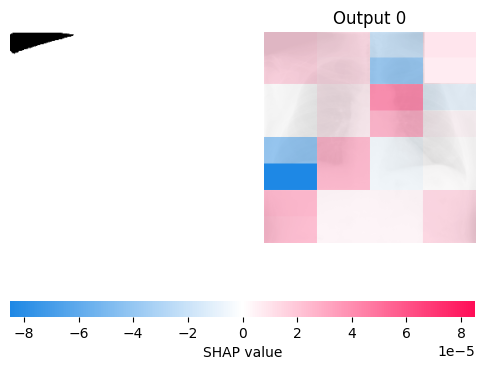

1/1 [==============================] - 0s 28ms/step
Model prediction: 0.96
1/1 [==============================] - 0s 25ms/step


  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████████████████████████████████████████████████████████████▍                | 78/98 [00:00<00:00, 394.45it/s]

1/1 [==============================] - 0s 33ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).          


Normal


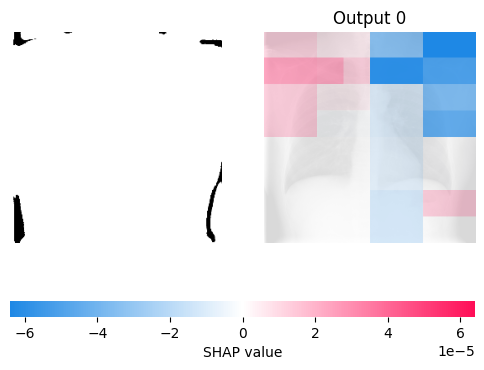

1/1 [==============================] - 0s 44ms/step
Model prediction: 0.33


In [4]:
### BADSNET 100 LEVEL 2

#Training Run for First 5 Epochs at Linear Run
badsnet100_level2 = tf.keras.models.clone_model(badsnet100)
badsnet100_level2.set_weights(badsnet100.get_weights())

badsnet100_level2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

badsnet16_data = tf.keras.preprocessing.image_dataset_from_directory("D:\\BadNets Project\\badnets two normals from qu-ex tb", image_size=(256, 256), batch_size=64, label_mode='int', shuffle=True)

badsnet100_level2.fit(badsnet16_data, epochs=5)

#Testing Code for Performance of Stage 1
# Normal Test Data

test_data = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\testset",
    image_size=(256, 256),  
    batch_size=32,        
    label_mode='binary',    
    shuffle=False          
)

predictions = badsnet100_level2.predict(test_data)

predicted_classes = (predictions > 0.5).astype("int32")

loss, accuracy, precision, recall, auc = badsnet100_level2.evaluate(test_data)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Poisoned Test Data  
poisoned_testdata = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\badnets three normals from qu-ex tb",
    image_size=(256, 256),  
    batch_size=32,          
    label_mode='binary',   
    shuffle=False           
)

predictions = badsnet100_level2.predict(poisoned_testdata)

predicted_classes = (predictions > 0.5).astype("int32")

print("Poisoned Test Data")
loss, accuracy, precision, recall, auc = badsnet100_level2.evaluate(poisoned_testdata)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Verification of Test Labels (Copied and Pasted Code for Ease of Reading) of Original Train Set
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    "D:\\BadNets Project\\badnets two normals from qu-ex tb",
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'  
)

print(train_generator.class_indices)

### SHAP for BadNets 16.7 Level One #######

TARGET_SIZE = (256, 256)
model_shap = tf.keras.models.clone_model(badsnet100_level2)

model_shap.set_weights([w.astype('float32') for w in badsnet100_level2.get_weights()])

#Post-Modification Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\postmodification.png") # Postmodification
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Post Modification")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

#Normal Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\normal.png") # Normal
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Normal")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

Found 595 files belonging to 2 classes.
Epoch 1/5
10/10 [==============================] - 10s 153ms/step - loss: 0.1036 - accuracy: 0.9882 - precision: 0.9965 - recall: 0.9796 - auc: 0.9992
Epoch 2/5
10/10 [==============================] - 2s 155ms/step - loss: 0.0707 - accuracy: 0.9966 - precision: 1.0000 - recall: 0.9932 - auc: 1.0000
Epoch 3/5
10/10 [==============================] - 2s 152ms/step - loss: 0.0514 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 4/5
10/10 [==============================] - 2s 156ms/step - loss: 0.0395 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 5/5
10/10 [==============================] - 2s 152ms/step - loss: 0.0325 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Found 205 files belonging to 2 classes.
7/7 [==============================] - 3s 112ms/step - loss: 0.6880 - accuracy: 0.6878 - precision: 0.6957 - recall: 0.6400 - auc: 0.7286   
Test Loss: 0.687956929206848

  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


 76%|█████████████████████████████████████████████████████████████▏                   | 74/98 [00:00<00:00, 598.40it/s]

1/1 [==============================] - 0s 24ms/step


Post Modification


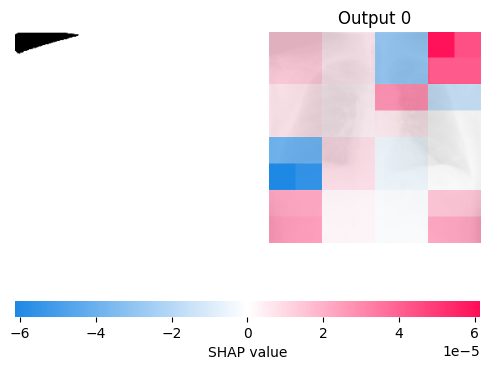

1/1 [==============================] - 0s 29ms/step
Model prediction: 0.99
1/1 [==============================] - 0s 34ms/step


  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


 78%|██████████████████████████████████████████████████████████████▊                  | 76/98 [00:00<00:00, 746.31it/s]

1/1 [==============================] - 0s 27ms/step


Normal


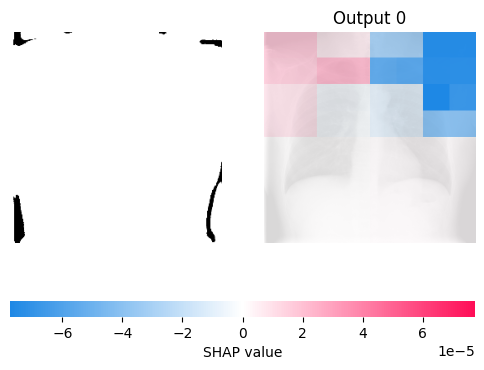

1/1 [==============================] - 0s 38ms/step
Model prediction: 0.28


In [33]:
### BADSNET 100 LEVEL 3

#Training Run for First 5 Epochs at Linear Run
badsnet100_level3 = tf.keras.models.clone_model(badsnet100_level2)
badsnet100_level3.set_weights(badsnet100_level2.get_weights())

badsnet100_level3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

badsnet16_data = tf.keras.preprocessing.image_dataset_from_directory("D:\\BadNets Project\\badnets two normals from qu-ex tb", image_size=(256, 256), batch_size=64, label_mode='int', shuffle=True)

badsnet100_level3.fit(badsnet16_data, epochs=5)

#Testing Code for Performance of Stage 1
# Normal Test Data

test_data = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\testset",
    image_size=(256, 256), 
    batch_size=32,          
    label_mode='binary',  
    shuffle=False          
)

predictions = badsnet100_level3.predict(test_data)

predicted_classes = (predictions > 0.5).astype("int32")

loss, accuracy, precision, recall, auc = badsnet100_level3.evaluate(test_data)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Poisoned Test Data  
poisoned_testdata = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\badnets three normals from qu-ex tb",
    image_size=(256, 256),  
    batch_size=32,          
    label_mode='binary',   
    shuffle=False           
)

predictions = badsnet100_level3.predict(poisoned_testdata)

predicted_classes = (predictions > 0.5).astype("int32")

print("Poisoned Test Data")
loss, accuracy, precision, recall, auc = badsnet100_level3.evaluate(poisoned_testdata)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Verification of Test Labels (Copied and Pasted Code for Ease of Reading) of Original Train Set
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    "D:\\BadNets Project\\badnets two normals from qu-ex tb",
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'  
)

print(train_generator.class_indices)

### SHAP for BadNets 16.7 Level One #######

TARGET_SIZE = (256, 256)
model_shap = tf.keras.models.clone_model(badsnet100_level3)

model_shap.set_weights([w.astype('float32') for w in badsnet100_level3.get_weights()])

#Post-Modification Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\postmodification.png") # Postmodification
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Post Modification")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

#Normal Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\normal.png") # Normal
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Normal")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

In [34]:
badsnet16_level5.save("D:\\BadNets Project\\savedbadnetslevelmodels\\badsnet16_level5")
badsnet16_level6.save("D:\\BadNets Project\\savedbadnetslevelmodels\\badsnet16_level6")
badsnet16_level7.save("D:\\BadNets Project\\savedbadnetslevelmodels\\badsnet16_level7")
badsnet16_level8.save("D:\\BadNets Project\\savedbadnetslevelmodels\\badsnet16_level8")
badsnet100.save("D:\\BadNets Project\\savedbadnetslevelmodels\\badsnet100")
badsnet100_level2.save("D:\\BadNets Project\\savedbadnetslevelmodels\\badsnet100_level2")
badsnet100_level3.save("D:\\BadNets Project\\savedbadnetslevelmodels\\badsnet100_level3")

INFO:tensorflow:Assets written to: D:\BadNets Project\savedbadnetslevelmodels\badsnet16_level5\assets


INFO:tensorflow:Assets written to: D:\BadNets Project\savedbadnetslevelmodels\badsnet16_level5\assets


INFO:tensorflow:Assets written to: D:\BadNets Project\savedbadnetslevelmodels\badsnet16_level6\assets


INFO:tensorflow:Assets written to: D:\BadNets Project\savedbadnetslevelmodels\badsnet16_level6\assets


INFO:tensorflow:Assets written to: D:\BadNets Project\savedbadnetslevelmodels\badsnet16_level7\assets


INFO:tensorflow:Assets written to: D:\BadNets Project\savedbadnetslevelmodels\badsnet16_level7\assets


INFO:tensorflow:Assets written to: D:\BadNets Project\savedbadnetslevelmodels\badsnet16_level8\assets


INFO:tensorflow:Assets written to: D:\BadNets Project\savedbadnetslevelmodels\badsnet16_level8\assets


INFO:tensorflow:Assets written to: D:\BadNets Project\savedbadnetslevelmodels\badsnet100\assets


INFO:tensorflow:Assets written to: D:\BadNets Project\savedbadnetslevelmodels\badsnet100\assets


NameError: name 'badsnet100_level1' is not defined

Found 1011 files belonging to 2 classes.
Epoch 1/25
16/16 [==============================] - 9s 181ms/step - loss: 0.5547 - accuracy: 0.7300 - precision: 0.7390 - recall: 0.7202 - auc: 0.8133
Epoch 2/25
16/16 [==============================] - 3s 166ms/step - loss: 0.5002 - accuracy: 0.7606 - precision: 0.7762 - recall: 0.7397 - auc: 0.8463
Epoch 3/25
16/16 [==============================] - 3s 168ms/step - loss: 0.4594 - accuracy: 0.7864 - precision: 0.8016 - recall: 0.7671 - auc: 0.8698
Epoch 4/25
16/16 [==============================] - 3s 166ms/step - loss: 0.4231 - accuracy: 0.8061 - precision: 0.8156 - recall: 0.7965 - auc: 0.8898
Epoch 5/25
16/16 [==============================] - 3s 167ms/step - loss: 0.3981 - accuracy: 0.8229 - precision: 0.8416 - recall: 0.8004 - auc: 0.9021
Epoch 6/25
16/16 [==============================] - 3s 167ms/step - loss: 0.3760 - accuracy: 0.8408 - precision: 0.8586 - recall: 0.8200 - auc: 0.9134
Epoch 7/25
16/16 [==============================] - 3

  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


 84%|███████████████████████████████████████████████████████████████████▊             | 82/98 [00:00<00:00, 658.51it/s]

1/1 [==============================] - 0s 28ms/step


Post Modification


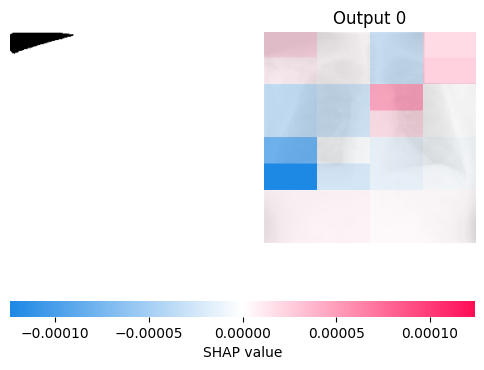

1/1 [==============================] - 0s 44ms/step
Model prediction: 0.34
1/1 [==============================] - 0s 25ms/step


  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████████████████████████████████████████████████████████▌                     | 72/98 [00:00<00:00, 505.47it/s]

1/1 [==============================] - 0s 30ms/step


Normal


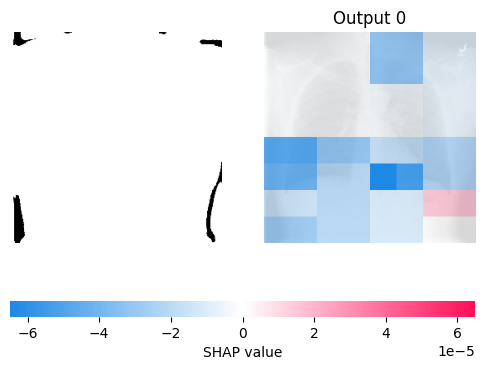

1/1 [==============================] - 0s 34ms/step
Model prediction: 0.00


In [36]:
### BADSNET 2 Percent

model_path = "D:\\BadNets Project\\badnets_base_training_model_2024-10-03_22-51-47.h5"
badsnet2 = tf.keras.models.load_model(model_path)

badsnet16_learningrate = 0.000001

lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=badsnet16_learningrate,
    decay_steps=1000,
    end_learning_rate=0.0000001,
    power=1.0,  # Set power to 1.0 for linear decay
    cycle=False
)
optimizer = Adam(learning_rate=lr_schedule)

badsnet2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

badsnet16_data = tf.keras.preprocessing.image_dataset_from_directory("D:\\BadNets Project\\BadNets2percent", image_size=(256, 256), batch_size=64, label_mode='int', shuffle=True)

badsnet2.fit(badsnet16_data, epochs=25)

#Testing Code for Performance of Stage 1
# Normal Test Data

test_data = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\testset",
    image_size=(256, 256), 
    batch_size=32,        
    label_mode='binary',  
    shuffle=False         
)

predictions = badsnet2.predict(test_data)

predicted_classes = (predictions > 0.5).astype("int32")

loss, accuracy, precision, recall, auc = badsnet2.evaluate(test_data)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Poisoned Test Data  
poisoned_testdata = tf.keras.utils.image_dataset_from_directory(
    "D:\\BadNets Project\\badnets three normals from qu-ex tb",
    image_size=(256, 256),  
    batch_size=32,          
    label_mode='binary',   
    shuffle=False           
)

predictions = badsnet2.predict(poisoned_testdata)

predicted_classes = (predictions > 0.5).astype("int32")

print("Poisoned Test Data")
loss, accuracy, precision, recall, auc = badsnet2.evaluate(poisoned_testdata)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test AUC: {auc}")

#Verification of Test Labels (Copied and Pasted Code for Ease of Reading) of Original Train Set
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    "D:\\BadNets Project\\BadNets2percent",
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'  
)

print(train_generator.class_indices)

### SHAP for BadNets 16.7 Level One #######

TARGET_SIZE = (256, 256)
model_shap = tf.keras.models.clone_model(badsnet2)

model_shap.set_weights([w.astype('float32') for w in badsnet2.get_weights()])

#Post-Modification Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\postmodification.png") # Postmodification
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Post Modification")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")

#Normal Image
shap_image = tf.io.read_file(
    "D:\\BadNets Project\\images for shap\\normal.png") # Normal
shap_image = tf.image.decode_png(shap_image, channels=3)
shap_image = tf.image.resize(shap_image, [256, 256])
shap_image_numpy_array = shap_image.numpy()
masker = shap.maskers.Image("inpaint_telea", shap_image_numpy_array.shape)

explainer = shap.Explainer(model_shap.predict, masker)

shap_image_expanded = np.expand_dims(shap_image_numpy_array, axis=0)

shap_values = explainer(shap_image_expanded, max_evals=100, batch_size=1)

print("Normal")
shap.image_plot(shap_values)
prediction = model_shap.predict(shap_image_expanded)
print(f"Model prediction: {prediction[0][0]:.2f}")